In [1]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

C:\Users\Xiaomi\anaconda3\envs\fa-ml-course\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [3]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [4]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [5]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z.,!?]', ' ', text)
    text = text.lower()
    
    return text

In [6]:
preprocess_text('Hdjsf!!!!!998 ()')

'hdjsf!!!!!      '

In [7]:
preprocess_text(text)

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c  '

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [13]:
def binary(words, all_words):
    
    return [int(word in all_words) for word in words]
    
all_words = list(set(preprocess_text(text).split()))
parse_1 = binary(text.split('.')[0], all_words)

In [14]:
print(parse_1)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [15]:
df = pd.read_csv('surnames.csv')

In [16]:
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [19]:
unique_nationality = df['nationality'].unique().tolist()

In [20]:
dict_nationality = dict(zip(unique_nationality, range(len(unique_nationality))))

In [22]:
df['encode_nationality'] = df['nationality'].apply(lambda x: dict_nationality.get(x))

In [40]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [58]:
class Vocab:
    def __init__(self, data):
        data = data[['surname']].drop_duplicates()
        
        letters = data['surname'].apply(lambda x: list(x.lower()))
        letters = set(letters.sum())
        
        self.idx_to_token = dict(zip(range(1, len(letters) + 1), letters))
        self.idx_to_token[0] = ''
        self.token_to_idx = dict(zip(letters, range(1, len(letters) + 1)))
        self.token_to_idx[''] = 0
        self.vocab_len = len(self.idx_to_token)
        
        
vocab = Vocab(df)

In [59]:
import numpy as np

class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, surname):
        vector = list(np.zeros(17))
        surname = surname.lower()
        for i in range(len(surname)):
            vector[17 - len(surname) + i] = self.vocab.token_to_idx[surname[i]]

        return torch.FloatTensor(vector)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X.iloc[idx]).long(), torch.tensor(dict_nationality[self.y.iloc[idx]])

In [61]:
train_dataset = SurnamesDataset(df_train.surname, df_train.nationality, Vocab(df))
test_dataset = SurnamesDataset(df_test.surname, df_test.nationality, Vocab(df))

kernels = [17, 32, 32, 64, 64]
convs = torch.nn.Sequential()
for i in range(len(kernels) - 1):
    convs.add_module(f'conv {i}', torch.nn.Conv1d(kernels[i], kernels[i + 1], 3))
    convs.add_module(f'pooling {i}', torch.nn.MaxPool1d(2))
    convs.add_module(f'func {i}', torch.nn.LeakyReLU(0.1))

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab.vocab_len, 128),
    convs,
    torch.nn.Dropout(0.5),
    torch.nn.Flatten(),
    torch.nn.Linear(384, 1024),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, len(dict_nationality))
)

In [74]:
%%time

optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()
loss_train_list = []
loss_test_list = []
min_test_loss = np.inf

for i in range(10):
    loss_train = 0
    loss_test = 0

    j, k = 1, 1  

    model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(train_dataset, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        loss_train += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(test_dataset, batch_size=64), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        loss_test += running_loss.item()

    loss_train /= j
    loss_test /= k

    if loss_test < min_test_loss:
        min_test_loss = loss_test
        torch.save(model.state_dict(), 'model_surname.pt')

    print(f"Epoch {i}\n"
         f"Test loss {loss_test}\n"
         f"Train loss {loss_train}")
    print('-' * 20)

    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)

model.load_state_dict(torch.load('model_surname.pt'))

Epoch 0
Test loss 1.0195990800857544
Train loss 0.5948613029459249
--------------------
Epoch 1
Test loss 1.010890847758243
Train loss 0.5633273396802985
--------------------
Epoch 2
Test loss 1.0025203740387632
Train loss 0.5348036245159481
--------------------
Epoch 3
Test loss 1.0069916007811563
Train loss 0.5186132060444874
--------------------
Epoch 4
Test loss 1.0319454941833228
Train loss 0.5089681920797928
--------------------
Epoch 5
Test loss 1.0990964644833614
Train loss 0.4872417269841484
--------------------
Epoch 6
Test loss 1.063242495059967
Train loss 0.4707990835542264
--------------------
Epoch 7
Test loss 1.1354036697170191
Train loss 0.4744476626748624
--------------------
Epoch 8
Test loss 1.1042250886298062
Train loss 0.43817299176817354
--------------------
Epoch 9
Test loss 1.0876959583215546
Train loss 0.4286498170831929
--------------------
Wall time: 34.9 s


<All keys matched successfully>

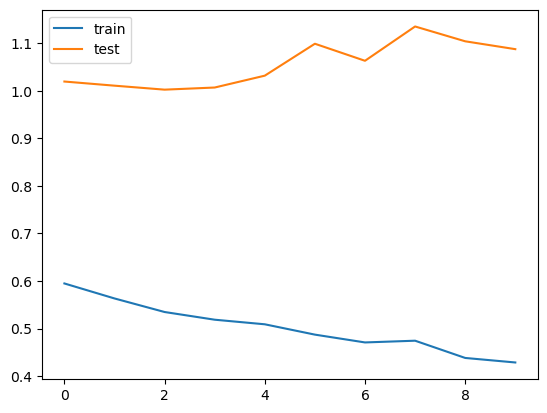

In [77]:
import matplotlib.pyplot as plt

plt.plot(loss_train_list, label='train')
plt.plot(loss_test_list, label='test')
plt.legend();

In [80]:
idx_to_nationalities = {v: u for u, v in dict_nationality.items()}

model.eval()
right_answers = 0
for batch_x, batch_y in DataLoader(train_dataset, batch_size=64):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'Train accuracy: {right_answers / len(train_dataset)}')

Train accuracy: 0.882816731929779


In [82]:
model.eval()
right_answers = 0
for batch_x, batch_y in DataLoader(test_dataset, batch_size=64):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'Test accuracy: {right_answers / len(test_dataset)}')

Test accuracy: 0.7204746007919312


In [83]:
def tokenize_surname(surname):
    dataset = SurnamesDataset(None, None, vocab)
    return dataset.vectorize(surname).reshape(1, 17).long()

In [85]:
tokenize_surname('borisov')

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 48,  5, 49, 42, 14,  5,  4]])

In [118]:
students = {
    'Borisov': 'Russian',
    'She': 'Chinese',
    'Kuliga': 'Russian',
    'Shekhovtsov': 'Russian',
    'Kazakova': 'Russian',
    'Mironovich': 'Russian',
    'Starikov': 'Russian',
    'Klose': 'German',
    'Muller': 'German'
}

for surname, nationality in students.items():
    model_pred = idx_to_nationalities[int(model(tokenize_surname(surname)).argmax(dim=1))]

    print(f'Surname {surname}')
    print(f'True: {nationality}\n'
         f'Pred: {model_pred}')
    print('-' * 20)

Surname Borisov
True: Russian
Pred: Russian
--------------------
Surname She
True: Chinese
Pred: Chinese
--------------------
Surname Kuliga
True: Russian
Pred: Japanese
--------------------
Surname Shekhovtsov
True: Russian
Pred: Russian
--------------------
Surname Kazakova
True: Russian
Pred: Czech
--------------------
Surname Mironovich
True: Russian
Pred: Russian
--------------------
Surname Starikov
True: Russian
Pred: Russian
--------------------
Surname Klose
True: German
Pred: English
--------------------
Surname Muller
True: German
Pred: English
--------------------


## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [131]:
df_train = pd.read_csv('raw_train.csv', names=['label', 'review'], header=None).sample(frac=0.1)
df_test = pd.read_csv('raw_test.csv', names=['label', 'review'], header=None)

In [132]:
df_train.head()

,label,review
439017,2,This place a has a really good burger and grea...
221161,2,"me, wifey and biggie had to do a vegas trip. B..."
209246,2,"So I'm standing here, still waiting for assist..."
338963,1,"Bland, so so"
470405,1,First off the staff here are amazing and surpr...


In [133]:
df_test.head()

,label,review
0,1,Ordered a large Mango-Pineapple smoothie. Stay...
1,2,Quite a surprise! \n\nMy wife and I loved thi...
2,1,"First I will say, this is a nice atmosphere an..."
3,2,I was overall pretty impressed by this hotel. ...
4,1,Video link at bottom review. Worst service I h...


In [134]:
df_train['label'].unique()

array([2, 1], dtype=int64)

In [135]:
df_train.reset_index(drop=True, inplace=True)

In [137]:
df_train['label'] = df_train['label'] - 1
df_test['label'] = df_test['label'] - 1

In [138]:
df_train['review'] = df_train['review'].apply(preprocess_text)
df_test['review'] = df_test['review'].apply(preprocess_text)

In [139]:
reviews_train, reviews_val = train_test_split(df_train, test_size=0.33)

In [149]:
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer(language='english')

class Vocab:
    def __init__(self, reviews):
        word_bag = set()
        for sent in reviews:
            sent = set(map(snow_stemmer.stem, word_tokenize(sent)))
            word_bag |= sent

        self.idx_to_token = dict(zip(range(1, len(word_bag) + 1), word_bag))

        self.token_to_idx = {v: u for u, v in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)


vocab_review = Vocab(reviews_train['review'])

In [170]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X.values
        self.y = y.values
        self.vocab = vocab

    def vectorize(self, review):
        review = review.lower()
        output_tensor = torch.zeros(124, dtype=torch.long)

        for i, word in enumerate(word_tokenize(review)[:124], 1):

            word = snow_stemmer.stem(word)
            if word in self.vocab.token_to_idx.keys():
                output_tensor[124 - i] = self.vocab.token_to_idx[word]

        return output_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.vectorize(self.X[idx])
        return X, torch.tensor(self.y[idx]).long()

In [171]:
d_val = ReviewDataset(reviews_val['review'], reviews_val['label'], vocab_review)

In [174]:
kernels = [124, 64, 128, 256]
convs = torch.nn.Sequential()
for i in range(len(kernels) - 1):
    convs.add_module(f'conv {i}', torch.nn.Conv1d(kernels[i], kernels[i + 1], 3))
    convs.add_module(f'pooling {i}', torch.nn.MaxPool1d(3))
    convs.add_module(f'func {i}', torch.nn.ReLU())
    convs.add_module(f'dropout {i}', torch.nn.Dropout(0.5))

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab_review.vocab_len + 1, 128),
    convs,
    torch.nn.Flatten(),
    torch.nn.Linear(768, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 2)
)

In [178]:
train_final = ReviewDataset(reviews_train['review'], reviews_train['label'], vocab_review)
val_final = ReviewDataset(reviews_val['review'], reviews_val['label'], vocab_review)

In [180]:
%%time

optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()
loss_train_list = []
loss_test_list = []
min_test_loss = np.inf

for i in range(4):
    loss_train = 0
    loss_test = 0

    j, k = 1, 1  

    model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(train_final, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        loss_train += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(val_final, batch_size=64), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        loss_test += running_loss.item()

    loss_train /= j
    loss_test /= k

    if loss_test < min_test_loss:
        min_test_loss = loss_test
        torch.save(model.state_dict(), 'model_surname.pt')

    print(f"Epoch {i}\n"
         f"Test loss {loss_test}\n"
         f"Train loss {loss_train}")
    print('-' * 20)

    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)

model.load_state_dict(torch.load('model_surname.pt'))

Epoch 0
Test loss 0.3208394374401924
Train loss 0.3269439144932635
--------------------
Epoch 1
Test loss 0.33712365212737483
Train loss 0.2886391437566463
--------------------
Epoch 2
Test loss 0.2989498794491316
Train loss 0.2594929777111166
--------------------
Epoch 3
Test loss 0.2933862428970403
Train loss 0.2319720901637711
--------------------
Wall time: 19min 3s


<All keys matched successfully>

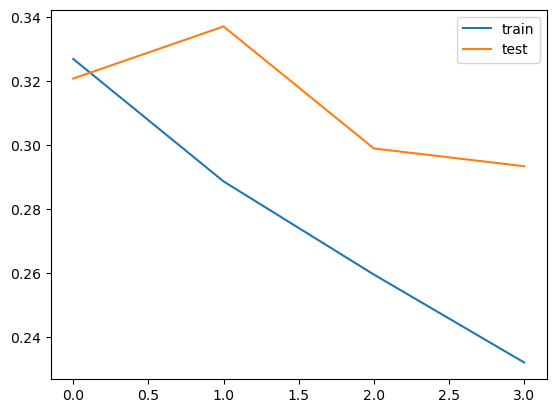

In [181]:
import matplotlib.pyplot as plt

plt.plot(loss_train_list, label='train')
plt.plot(loss_test_list, label='test')
plt.legend();

In [184]:
test_final = ReviewDataset(df_test['review'], df_test['label'], vocab_review)

In [185]:
model.eval()
right_answers = 0
for batch_x, batch_y in DataLoader(test_final, batch_size=64):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'Test accuracy: {right_answers / len(test_final)}')

Test accuracy: 0.8771842122077942


In [220]:
def vectorize(review):
        review = review.lower()
        output_tensor = torch.zeros(1, 124, dtype=torch.long)

        for i, word in enumerate(word_tokenize(review)[:124], 1):

            word = snow_stemmer.stem(word)
            if word in vocab_review.token_to_idx.keys():
                output_tensor[0, i] = vocab_review.token_to_idx[word]

        return output_tensor

In [228]:
model(vectorize('i like this. thanks for this very good service. nice cafe.')).argmax(1)

tensor([1])